# 伤害期望和最优数值关系

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

## 不考虑元素反应的情况下

In [2]:
characters = pd.DataFrame(
    [
        # 迪卢克升级加 19.2% 的暴击率，不考虑迪卢克天赋提供的附魔期间火元素伤害加成
        ['迪卢克', '双手剑', 335, .05 + .192, .5, 0],
        ['凝光', '法器', 212, .05, .5, .27]
    ],
    columns=['名字', '武器类型', '攻击力', '暴击率', '暴击伤害', '额外增伤'],
)

characters

,名字,武器类型,攻击力,暴击率,暴击伤害,额外增伤
0,迪卢克,双手剑,335,0.242,0.5,0.00
1,凝光,法器,212,0.050,0.5,0.27


In [39]:
# 武器都为精炼 1 的效果

weapons = pd.DataFrame(
    [
        # 30% 血量以下的敌人攻击力增加 40%，持续 12s，冷却 30s，计算期望增加攻击力 30%*40%*12/30
        ['狼的末路', '双手剑', 608, .496 + .2 + .3*.4*12/30, 0, 0, 0],
        # 螭骨剑的增伤效果一般在实战中视为为 2 层左右
        ['螭骨剑', '双手剑', 510, 0, .276, 0, .06 * 2],
        # 试作古华的伤害特效不考虑
        ['试作古华', '双手剑', 565, .276, 0, 0, 0],
        ['四风原典', '法器', 608, 0, .311, 0, .16],
        ['匣里日月', '法器', 510, 0, .276, 0, .05],
        ['天空之卷', '法器', 674, .331, 0, 0, .12]
        
    ],
    columns=['名称', '武器类型', '攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤'],
)

weapons

,名称,武器类型,攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤
0,狼的末路,双手剑,608,0.744,0.000,0,0.00
1,螭骨剑,双手剑,510,0.000,0.276,0,0.12
2,试作古华,双手剑,565,0.276,0.000,0,0.00
3,四风原典,法器,608,0.000,0.311,0,0.16
4,匣里日月,法器,510,0.000,0.276,0,0.05
5,天空之卷,法器,674,0.331,0.000,0,0.12


In [4]:
artifacts = pd.DataFrame(
    [
        # 卢姥爷释放元素战技三次一共增加元素伤害 15% + 7.5%*3 = 37.5%
        ['炽烈的炎之魔女', 0, 0, 0, 0, .15 + .075*3],
        ['悠古的磐岩', 0, 0, 0, 0, .15]
        
    ],
    columns=['名称', '数值攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤'],
)

artifacts

,名称,数值攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤
0,炽烈的炎之魔女,0,0,0,0,0.375
1,悠古的磐岩,0,0,0,0,0.150


In [5]:
# 输入主副词条属性值

attr_names = [
    '主_百分比攻击力', 
    '主_元素伤害', 
    '主_暴击率', 
    '主_暴击伤害',
    '副_数值攻击力',
    '副_百分比攻击力',
    '副_暴击率',
    '副_暴击伤害',
]
attr_values = [.466, .466, .311, .622, 17, .05, .033, .066]

In [6]:
def gen_sub_stats(sands, goblet, circlet):
    attr_len = len(attr_names)
    values = [0] * (attr_len * 2)
    half_len = int(attr_len / 2)
    
    # 录入主词条
    values[sands] += attr_values[sands]
    values[goblet] += attr_values[goblet]
    values[circlet] += attr_values[circlet]
    values[attr_len + sands] += 1
    values[attr_len + goblet] += 1
    values[attr_len + circlet] += 1
    
    # 初始出现的副词条（假设最好的情况，且不与主词条重复）
    ini_atk = 4
    ini_patk = 5 - values[attr_len]
    ini_crate = 5 - values[attr_len + 2]
    ini_cdmg = 5 - values[attr_len + 3]
    
    # 升级出现的副词条(枚举总数不超过 25)
    print('沙、杯、帽')
    print(sands, goblet, circlet)
    max_idx_atk = min(ini_atk * 5, 25)
    for idx_atk in range(max_idx_atk + 1):
        max_idx_patk = min(idx_atk + ini_patk * 5, 25)
        for idx_patk in range(idx_atk, max_idx_patk + 1):
            max_idx_crate = min(idx_patk + ini_crate * 5, 25)
            for idx_crate in range(idx_patk, max_idx_crate + 1):
                max_idx_cdmg = idx_crate + ini_cdmg * 5
                # 全部副词条不足 25 次，即不是全部加在攻击力，暴击爆伤上
                if max_idx_cdmg < 25:
                    continue
                up_atk = idx_atk
                up_patk = idx_patk - idx_atk
                up_crate = idx_crate - idx_patk
                up_cdmg = 25 - idx_crate
                values[attr_len + half_len + 0] = ini_atk + up_atk
                values[attr_len + half_len + 1] = ini_patk + up_patk
                values[attr_len + half_len + 2] = ini_crate + up_crate
                values[attr_len + half_len + 3] = ini_cdmg + up_cdmg
                for idx in range(4):
                    values[half_len + idx] = (
                        values[attr_len + half_len + idx] * 
                        attr_values[half_len + idx]
                    )
                equip_values.loc[len(equip_values)] = values

In [7]:
%%time

# 花和羽毛主词条固定，沙漏默认带攻击（不考虑元素反应），其他枚举
attr_cols = attr_names + [name + '_次数' for name in attr_names]
equip_values = pd.DataFrame(columns=attr_cols)

for goblet in [0, 1]:
    for circlet in [0, 2, 3]:
        gen_sub_stats(0, goblet, circlet)

equip_values.insert(0, '主_数值攻击力', 311)

equip_values.head(10)

沙、杯、帽
0 0 0
沙、杯、帽
0 0 2
沙、杯、帽
0 0 3
沙、杯、帽
0 1 0
沙、杯、帽
0 1 2
沙、杯、帽
0 1 3
CPU times: user 27 s, sys: 1.24 s, total: 28.2 s
Wall time: 29 s


,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数
0,311,1.398,0.0,0.0,0.0,68.0,0.1,0.165,1.980,3.0,0.0,0.0,0.0,4.0,2.0,5.0,30.0
1,311,1.398,0.0,0.0,0.0,68.0,0.1,0.198,1.914,3.0,0.0,0.0,0.0,4.0,2.0,6.0,29.0
2,311,1.398,0.0,0.0,0.0,68.0,0.1,0.231,1.848,3.0,0.0,0.0,0.0,4.0,2.0,7.0,28.0
3,311,1.398,0.0,0.0,0.0,68.0,0.1,0.264,1.782,3.0,0.0,0.0,0.0,4.0,2.0,8.0,27.0
4,311,1.398,0.0,0.0,0.0,68.0,0.1,0.297,1.716,3.0,0.0,0.0,0.0,4.0,2.0,9.0,26.0
5,311,1.398,0.0,0.0,0.0,68.0,0.1,0.330,1.650,3.0,0.0,0.0,0.0,4.0,2.0,10.0,25.0
6,311,1.398,0.0,0.0,0.0,68.0,0.1,0.363,1.584,3.0,0.0,0.0,0.0,4.0,2.0,11.0,24.0
7,311,1.398,0.0,0.0,0.0,68.0,0.1,0.396,1.518,3.0,0.0,0.0,0.0,4.0,2.0,12.0,23.0
8,311,1.398,0.0,0.0,0.0,68.0,0.1,0.429,1.452,3.0,0.0,0.0,0.0,4.0,2.0,13.0,22.0
9,311,1.398,0.0,0.0,0.0,68.0,0.1,0.462,1.386,3.0,0.0,0.0,0.0,4.0,2.0,14.0,21.0


In [8]:
len(equip_values)

17896

In [9]:
# 计算仅由圣遗物主副词条带来的数值

origin_names = ['数值攻击力', '百分比攻击力', '元素伤害', '暴击率', '暴击伤害']
for name in origin_names:
    main_stat = equip_values['主_' + name]
    sub_stat = (
        ('副_' + name) in equip_values.columns and 
        equip_values['副_' + name]
    )
    equip_values['总_' + name] = main_stat + sub_stat

equip_values['总_额外增伤'] = equip_values['总_元素伤害']
equip_values.head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤
0,311,1.398,0.0,0.0,0.0,68.0,0.1,0.165,1.980,3.0,0.0,0.0,0.0,4.0,2.0,5.0,30.0,379.0,1.498,0.0,0.165,1.980,0.0
1,311,1.398,0.0,0.0,0.0,68.0,0.1,0.198,1.914,3.0,0.0,0.0,0.0,4.0,2.0,6.0,29.0,379.0,1.498,0.0,0.198,1.914,0.0
2,311,1.398,0.0,0.0,0.0,68.0,0.1,0.231,1.848,3.0,0.0,0.0,0.0,4.0,2.0,7.0,28.0,379.0,1.498,0.0,0.231,1.848,0.0
3,311,1.398,0.0,0.0,0.0,68.0,0.1,0.264,1.782,3.0,0.0,0.0,0.0,4.0,2.0,8.0,27.0,379.0,1.498,0.0,0.264,1.782,0.0
4,311,1.398,0.0,0.0,0.0,68.0,0.1,0.297,1.716,3.0,0.0,0.0,0.0,4.0,2.0,9.0,26.0,379.0,1.498,0.0,0.297,1.716,0.0


In [10]:
def fit_ct(ct_name, af_name):
    results = []
    
    cts = characters[characters['名字'] == ct_name]
    wps = weapons[weapons['武器类型'] == cts['武器类型'].values[0]]
    afs = artifacts[artifacts['名称'] == af_name]
    
    for _, ct in cts.iterrows():
        for _, wp in wps.iterrows():
            for _, af in afs.iterrows():
                print(ct['名字'], wp['名称'], af['名称'])
                # 加成人物和武器的属性
                e_values = equip_values.copy()
                for attr in ct.index[3:]:
                    e_values['总_' + attr] += ct[attr]
                for attr in wp.index[3:]:
                    e_values['总_' + attr] += wp[attr]
                for attr in af.index[1:]:
                    e_values['总_' + attr] += af[attr]

                print(ct['攻击力'], wp['攻击力'])

                e_values['期望伤害'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) *
                    (1 + e_values['总_额外增伤']) *
                    (
                        1 + 
                        # 暴击率超过 1，只能按 1 计算
                        e_values['总_暴击率'].where(e_values['总_暴击率'] < 1, 1) * 
                        e_values['总_暴击伤害']
                    )
                )

                e_values['总攻击力倍数'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) / 
                    (ct['攻击力'] + wp['攻击力'])
                )

                e_values['暴击率推导的总攻击力倍数'] = 1.52 * (
                    1 / (2 * e_values['总_暴击率']) + e_values['总_暴击率']
                )

                res = e_values.sort_values('期望伤害', ascending=False)
                print(res.iloc[:5])
                results.append(res)
                # res.to_csv(ct['名字'] + '_' + wp['名称'] + '_' + af['名称'] +'.csv')

    return results

In [11]:
results = fit_ct('迪卢克', '炽烈的炎之魔女')

迪卢克 狼的末路 炽烈的炎之魔女
335 608
       主_数值攻击力  主_百分比攻击力  主_元素伤害  主_暴击率  主_暴击伤害  副_数值攻击力  副_百分比攻击力  副_暴击率  \
14737      311     0.466   0.466  0.000   0.622     68.0       0.2  0.726   
11562      311     0.466   0.466  0.311   0.000     68.0       0.2  0.396   
11563      311     0.466   0.466  0.311   0.000     68.0       0.2  0.429   
14736      311     0.466   0.466  0.000   0.622     68.0       0.2  0.693   
11561      311     0.466   0.466  0.311   0.000     68.0       0.2  0.363   

       副_暴击伤害  主_百分比攻击力_次数  主_元素伤害_次数  主_暴击率_次数  主_暴击伤害_次数  副_数值攻击力_次数  \
14737   0.792          1.0        1.0       0.0        1.0         4.0   
11562   1.452          1.0        1.0       1.0        0.0         4.0   
11563   1.386          1.0        1.0       1.0        0.0         4.0   
14736   0.858          1.0        1.0       0.0        1.0         4.0   
11561   1.518          1.0        1.0       1.0        0.0         4.0   

       副_百分比攻击力_次数  副_暴击率_次数  副_暴击伤害_次数  总_数值攻击力  总_百分比攻击力  总_元素伤害 

In [12]:
results[0].iloc[:10]

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14737,311,0.466,0.466,0.000,0.622,68.0,0.20,0.726,0.792,1.0,1.0,0.0,1.0,4.0,4.0,22.0,12.0,379.0,1.41,0.466,0.968,1.914,0.841,13926.139169,2.811909,2.256484
11562,311,0.466,0.466,0.311,0.000,68.0,0.20,0.396,1.452,1.0,1.0,1.0,0.0,4.0,4.0,12.0,22.0,379.0,1.41,0.466,0.949,1.952,0.841,13924.655147,2.811909,2.243323
11563,311,0.466,0.466,0.311,0.000,68.0,0.20,0.429,1.386,1.0,1.0,1.0,0.0,4.0,4.0,13.0,21.0,379.0,1.41,0.466,0.982,1.886,0.841,13922.722013,2.811909,2.266571
14736,311,0.466,0.466,0.000,0.622,68.0,0.20,0.693,0.858,1.0,1.0,0.0,1.0,4.0,4.0,21.0,13.0,379.0,1.41,0.466,0.935,1.980,0.841,13919.051012,2.811909,2.234034
11561,311,0.466,0.466,0.311,0.000,68.0,0.20,0.363,1.518,1.0,1.0,1.0,0.0,4.0,4.0,11.0,23.0,379.0,1.41,0.466,0.916,2.018,0.841,13905.323809,2.811909,2.222014
14738,311,0.466,0.466,0.000,0.622,68.0,0.20,0.759,0.726,1.0,1.0,0.0,1.0,4.0,4.0,23.0,11.0,379.0,1.41,0.466,1.001,1.848,0.841,13902.941564,2.811909,2.280761
14735,311,0.466,0.466,0.000,0.622,68.0,0.20,0.660,0.924,1.0,1.0,0.0,1.0,4.0,4.0,20.0,14.0,379.0,1.41,0.466,0.902,2.046,0.841,13890.698384,2.811909,2.213612
11560,311,0.466,0.466,0.311,0.000,68.0,0.20,0.330,1.584,1.0,1.0,1.0,0.0,4.0,4.0,10.0,24.0,379.0,1.41,0.466,0.883,2.084,0.841,13864.728001,2.811909,2.202862
11583,311,0.466,0.466,0.311,0.000,68.0,0.25,0.396,1.386,1.0,1.0,1.0,0.0,4.0,5.0,12.0,21.0,379.0,1.46,0.466,0.949,1.886,0.841,13861.062472,2.861909,2.243323
14758,311,0.466,0.466,0.000,0.622,68.0,0.25,0.693,0.792,1.0,1.0,0.0,1.0,4.0,5.0,21.0,12.0,379.0,1.46,0.466,0.935,1.914,0.841,13859.949538,2.861909,2.234034


In [13]:
results[1].iloc[:10]

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
11660,311,0.466,0.466,0.311,0.000,68.0,0.45,0.165,1.584,1.0,1.0,1.0,0.0,4.0,9.0,5.0,24.0,379.0,0.916,0.466,0.994,2.084,0.961,12034.481369,2.364521,2.275468
11639,311,0.466,0.466,0.311,0.000,68.0,0.40,0.165,1.650,1.0,1.0,1.0,0.0,4.0,8.0,5.0,25.0,379.0,0.866,0.466,0.994,2.150,0.961,12031.609737,2.314521,2.275468
14839,311,0.466,0.466,0.000,0.622,68.0,0.45,0.462,0.990,1.0,1.0,0.0,1.0,4.0,9.0,14.0,15.0,379.0,0.916,0.466,0.980,2.112,0.961,12027.679517,2.364521,2.265110
11681,311,0.466,0.466,0.311,0.000,68.0,0.50,0.165,1.518,1.0,1.0,1.0,0.0,4.0,10.0,5.0,23.0,379.0,0.966,0.466,0.994,2.018,0.961,12026.482122,2.414521,2.275468
14860,311,0.466,0.466,0.000,0.622,68.0,0.50,0.462,0.924,1.0,1.0,0.0,1.0,4.0,10.0,14.0,14.0,379.0,0.966,0.466,0.980,2.046,0.961,12023.233335,2.414521,2.265110
14817,311,0.466,0.466,0.000,0.622,68.0,0.40,0.462,1.056,1.0,1.0,0.0,1.0,4.0,8.0,14.0,16.0,379.0,0.866,0.466,0.980,2.178,0.961,12021.407933,2.314521,2.265110
11618,311,0.466,0.466,0.311,0.000,68.0,0.35,0.165,1.716,1.0,1.0,1.0,0.0,4.0,7.0,5.0,26.0,379.0,0.816,0.466,0.994,2.216,0.961,12017.867228,2.264521,2.275468
11680,311,0.466,0.466,0.311,0.000,68.0,0.50,0.132,1.584,1.0,1.0,1.0,0.0,4.0,10.0,4.0,24.0,379.0,0.966,0.466,0.961,2.084,0.961,12013.807051,2.414521,2.251563
11659,311,0.466,0.466,0.311,0.000,68.0,0.45,0.132,1.650,1.0,1.0,1.0,0.0,4.0,9.0,4.0,25.0,379.0,0.916,0.466,0.961,2.150,0.961,12013.535114,2.364521,2.251563
14880,311,0.466,0.466,0.000,0.622,68.0,0.55,0.462,0.858,1.0,1.0,0.0,1.0,4.0,11.0,14.0,13.0,379.0,1.016,0.466,0.980,1.980,0.961,12008.069385,2.464521,2.265110


In [14]:
results[2].iloc[:10]

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14737,311,0.466,0.466,0.000,0.622,68.0,0.20,0.726,0.792,1.0,1.0,0.0,1.0,4.0,4.0,22.0,12.0,379.0,0.942,0.466,0.968,1.914,0.841,11169.775868,2.363111,2.256484
11562,311,0.466,0.466,0.311,0.000,68.0,0.20,0.396,1.452,1.0,1.0,1.0,0.0,4.0,4.0,12.0,22.0,379.0,0.942,0.466,0.949,1.952,0.841,11168.585574,2.363111,2.243323
11563,311,0.466,0.466,0.311,0.000,68.0,0.20,0.429,1.386,1.0,1.0,1.0,0.0,4.0,4.0,13.0,21.0,379.0,0.942,0.466,0.982,1.886,0.841,11167.035060,2.363111,2.266571
14736,311,0.466,0.466,0.000,0.622,68.0,0.20,0.693,0.858,1.0,1.0,0.0,1.0,4.0,4.0,21.0,13.0,379.0,0.942,0.466,0.935,1.980,0.841,11164.090650,2.363111,2.234034
11583,311,0.466,0.466,0.311,0.000,68.0,0.25,0.396,1.386,1.0,1.0,1.0,0.0,4.0,5.0,12.0,21.0,379.0,0.992,0.466,0.949,1.886,0.841,11154.468121,2.413111,2.243323
14758,311,0.466,0.466,0.000,0.622,68.0,0.25,0.693,0.792,1.0,1.0,0.0,1.0,4.0,5.0,21.0,12.0,379.0,0.992,0.466,0.935,1.914,0.841,11153.572506,2.413111,2.234034
11561,311,0.466,0.466,0.311,0.000,68.0,0.20,0.363,1.518,1.0,1.0,1.0,0.0,4.0,4.0,11.0,23.0,379.0,0.942,0.466,0.916,2.018,0.841,11153.080437,2.363111,2.222014
14738,311,0.466,0.466,0.000,0.622,68.0,0.20,0.759,0.726,1.0,1.0,0.0,1.0,4.0,4.0,23.0,11.0,379.0,0.942,0.466,1.001,1.848,0.841,11151.169702,2.363111,2.280761
14759,311,0.466,0.466,0.000,0.622,68.0,0.25,0.726,0.726,1.0,1.0,0.0,1.0,4.0,5.0,22.0,11.0,379.0,0.992,0.466,0.968,1.848,0.841,11150.669752,2.413111,2.256484
11582,311,0.466,0.466,0.311,0.000,68.0,0.25,0.363,1.452,1.0,1.0,1.0,0.0,4.0,5.0,11.0,22.0,379.0,0.992,0.466,0.916,1.952,0.841,11147.343179,2.413111,2.222014


In [40]:
results = fit_ct('凝光', '悠古的磐岩')

凝光 四风原典 悠古的磐岩
212 608
       主_数值攻击力  主_百分比攻击力  主_元素伤害  主_暴击率  主_暴击伤害  副_数值攻击力  副_百分比攻击力  副_暴击率  \
11622      311     0.466   0.466  0.311   0.000     68.0      0.35  0.297   
14778      311     0.466   0.466  0.000   0.622     68.0      0.30  0.627   
14800      311     0.466   0.466  0.000   0.622     68.0      0.35  0.627   
14799      311     0.466   0.466  0.000   0.622     68.0      0.35  0.594   
11601      311     0.466   0.466  0.311   0.000     68.0      0.30  0.297   

       副_暴击伤害  主_百分比攻击力_次数  主_元素伤害_次数  主_暴击率_次数  主_暴击伤害_次数  副_数值攻击力_次数  \
11622   1.452          1.0        1.0       1.0        0.0         4.0   
14778   0.858          1.0        1.0       0.0        1.0         4.0   
14800   0.792          1.0        1.0       0.0        1.0         4.0   
14799   0.858          1.0        1.0       0.0        1.0         4.0   
11601   1.518          1.0        1.0       1.0        0.0         4.0   

       副_百分比攻击力_次数  副_暴击率_次数  副_暴击伤害_次数  总_数值攻击力  总_百分比攻击力  总_元素伤害  总_

In [41]:
results[0].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
11622,311,0.466,0.466,0.311,0.000,68.0,0.35,0.297,1.452,1.0,1.0,1.0,0.0,4.0,7.0,9.0,22.0,379.0,0.816,0.466,0.969,1.952,1.046,11051.768867,2.278195,2.257194
14778,311,0.466,0.466,0.000,0.622,68.0,0.30,0.627,0.858,1.0,1.0,0.0,1.0,4.0,6.0,19.0,13.0,379.0,0.766,0.466,0.988,1.980,1.046,11051.275098,2.228195,2.270991
14800,311,0.466,0.466,0.000,0.622,68.0,0.35,0.627,0.792,1.0,1.0,0.0,1.0,4.0,7.0,19.0,12.0,379.0,0.816,0.466,0.988,1.914,1.046,11050.025956,2.278195,2.270991
14799,311,0.466,0.466,0.000,0.622,68.0,0.35,0.594,0.858,1.0,1.0,0.0,1.0,4.0,7.0,18.0,13.0,379.0,0.816,0.466,0.955,1.980,1.046,11049.521429,2.278195,2.247412
11601,311,0.466,0.466,0.311,0.000,68.0,0.30,0.297,1.518,1.0,1.0,1.0,0.0,4.0,6.0,9.0,23.0,379.0,0.766,0.466,0.969,2.018,1.046,11048.291945,2.228195,2.257194


In [42]:
# 凝光带匣里日月
results[1].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14757,311,0.466,0.466,0.000,0.622,68.0,0.25,0.660,0.858,1.0,1.0,0.0,1.0,4.0,5.0,20.0,13.0,379.0,0.716,0.466,0.986,1.980,0.936,9247.589232,2.240931,2.269511
11602,311,0.466,0.466,0.311,0.000,68.0,0.30,0.330,1.452,1.0,1.0,1.0,0.0,4.0,6.0,10.0,22.0,379.0,0.766,0.466,0.967,1.952,0.936,9246.750479,2.290931,2.255776
11582,311,0.466,0.466,0.311,0.000,68.0,0.25,0.363,1.452,1.0,1.0,1.0,0.0,4.0,5.0,11.0,22.0,379.0,0.716,0.466,1.000,1.952,0.936,9246.712173,2.240931,2.280000
14779,311,0.466,0.466,0.000,0.622,68.0,0.30,0.660,0.792,1.0,1.0,0.0,1.0,4.0,6.0,20.0,12.0,379.0,0.766,0.466,0.986,1.914,0.936,9245.533626,2.290931,2.269511
11581,311,0.466,0.466,0.311,0.000,68.0,0.25,0.330,1.518,1.0,1.0,1.0,0.0,4.0,5.0,10.0,23.0,379.0,0.716,0.466,0.967,2.018,0.936,9244.851554,2.240931,2.255776


In [44]:
# 凝光带天空之卷
results[2].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_额外增伤,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
14740,311,0.466,0.466,0.000,0.622,68.0,0.2,0.825,0.594,1.0,1.0,0.0,1.0,4.0,4.0,25.0,9.0,379.0,0.997,0.466,0.875,1.716,1.006,10780.399491,2.424765,2.198571
11565,311,0.466,0.466,0.311,0.000,68.0,0.2,0.495,1.254,1.0,1.0,1.0,0.0,4.0,4.0,15.0,19.0,379.0,0.997,0.466,0.856,1.754,1.006,10780.071963,2.424765,2.188970
11566,311,0.466,0.466,0.311,0.000,68.0,0.2,0.528,1.188,1.0,1.0,1.0,0.0,4.0,4.0,16.0,18.0,379.0,0.997,0.466,0.889,1.688,1.006,10776.658781,2.424765,2.206173
14739,311,0.466,0.466,0.000,0.622,68.0,0.2,0.792,0.660,1.0,1.0,0.0,1.0,4.0,4.0,24.0,10.0,379.0,0.997,0.466,0.842,1.782,1.006,10775.848581,2.424765,2.182453
14741,311,0.466,0.466,0.000,0.622,68.0,0.2,0.858,0.528,1.0,1.0,0.0,1.0,4.0,4.0,26.0,8.0,379.0,0.997,0.466,0.908,1.650,1.006,10766.177897,2.424765,2.217164


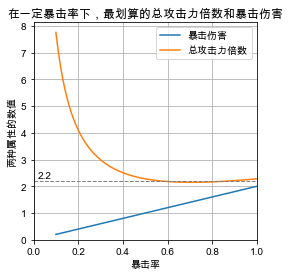

In [35]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

crate = np.arange(0.1, 1.01, 0.01)
cdmg = crate * 2
atk_ratio = 1.52 * (1/(2*crate) + crate)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(crate, cdmg, label='暴击伤害')
ax.plot(crate, atk_ratio, label='总攻击力倍数')
ax.plot([0, 1], [2.2, 2.2], '--', linewidth=1, color='grey')
ax.annotate('2.2', (0.02, 2.3))
ax.set_title('在一定暴击率下，最划算的总攻击力倍数和暴击伤害')
ax.set_ylabel('两种属性的数值')
ax.set_xlabel('暴击率')
ax.legend(loc='best')
ax.set_ylim(0)
ax.set_xlim(0, 1)
ax.grid()

fig.savefig('暴击暴伤和总攻击力倍数.png', dpi=800)

## 考虑元素反应的情况下

In [2]:
characters = pd.DataFrame(
    [
        ['迪卢克', '双手剑', 335, .05 + .192, 0.5, .2, 0],
    ],
    columns=['名字', '武器类型', '攻击力', '暴击率', '暴击伤害', '额外增伤', '反应强度'],
)

characters

,名字,武器类型,攻击力,暴击率,暴击伤害,额外增伤,反应强度
0,迪卢克,双手剑,335,0.242,0.5,0.2,0


In [71]:
weapons = pd.DataFrame(
    [
        # 30% 血量以下的敌人攻击力增加 40%，持续 12s，冷却 30s，计算期望增加攻击力 30%*40%*12/30
        ['狼的末路', '双手剑', 608, .496 + .2 + .3*.4*12/30, 0, 0, 0, 0],
        # 螭骨剑的增伤效果一般在实战中视为为 2 层左右
        ['螭骨剑', '双手剑', 510, 0, .276, 0, .06 * 2, 0],
        # 试作古华的伤害特效不考虑
        ['试作古华', '双手剑', 565, .276, 0, 0, 0, 0],
        ['雨裁', '双手剑', 510, 0, 0, 0, .15, 165],
        ['天空之傲', '双手剑', 674, 0, 0, 0, .08, 0]
        
    ],
    columns=['名称', '武器类型', '攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤', '元素精通'],
)

weapons

,名称,武器类型,攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤,元素精通
0,狼的末路,双手剑,608,0.744,0.000,0,0.00,0
1,螭骨剑,双手剑,510,0.000,0.276,0,0.12,0
2,试作古华,双手剑,565,0.276,0.000,0,0.00,0
3,雨裁,双手剑,510,0.000,0.000,0,0.15,165
4,天空之傲,双手剑,674,0.000,0.000,0,0.08,0


In [4]:
artifacts = pd.DataFrame(
    [
        # 卢姥爷释放元素战技三次一共增加元素伤害 15% + 7.5%*3 = 37.5%
        ['炽烈的炎之魔女', 0, 0, 0, 0, .15 + .075*3, .15],
        
    ],
    columns=['名称', '数值攻击力', '百分比攻击力', '暴击率', '暴击伤害', '额外增伤', '反应强度'],
)

artifacts

,名称,数值攻击力,百分比攻击力,暴击率,暴击伤害,额外增伤,反应强度
0,炽烈的炎之魔女,0,0,0,0,0.375,0.15


In [5]:
attr_names = [
    '主_百分比攻击力', 
    '主_元素伤害', 
    '主_暴击率', 
    '主_暴击伤害',
    '主_元素精通',
    '副_数值攻击力',
    '副_百分比攻击力',
    '副_暴击率',
    '副_暴击伤害',
    '副_元素精通',
]
attr_values = [.466, .466, .311, .622, 187, 17, .05, .033, .066, 20]

In [6]:
def gen_sub_stats_re(sands, goblet, circlet):
    values = [0] * (len(attr_names) * 2)
    half_len = int(len(values) / 2)
    
    # 录入主词条
    values[sands] += attr_values[sands]
    values[goblet] += attr_values[goblet]
    values[circlet] += attr_values[circlet]
    values[half_len + sands] += 1
    values[half_len + goblet] += 1
    values[half_len + circlet] += 1
    
    # 初始出现的副词条（假设最好的情况）
    ini_atk = 3
    ini_patk = 5 - values[half_len]
    ini_crate = 5 - values[half_len + 2]
    ini_cdmg = 5 - values[half_len + 3]
    ini_em = 5 - values[half_len + 4]
    
    # 升级出现的副词条(枚举总数不超过 25)
    print('沙、杯、帽')
    print(sands, goblet, circlet)
    max_idx_patk = min(ini_patk * 5, 25)
    for idx_patk in range(max_idx_patk + 1):
        max_idx_crate = min(idx_patk + ini_crate * 5, 25)
        for idx_crate in range(idx_patk, max_idx_crate + 1):
            max_idx_cdmg = min(idx_crate + ini_cdmg * 5, 25)
            for idx_cdmg in range(idx_crate, max_idx_cdmg + 1):
                max_idx_em = idx_cdmg + ini_em * 5
                if max_idx_em < 25:
                    continue
                up_atk = 0
                up_patk = idx_patk
                up_crate = idx_crate - idx_patk
                up_cdmg = idx_cdmg - idx_crate
                up_em = 25 - idx_cdmg
                values[half_len + 5] = ini_atk + up_atk
                values[half_len + 6] = ini_patk + up_patk
                values[half_len + 7] = ini_crate + up_crate
                values[half_len + 8] = ini_cdmg + up_cdmg
                values[half_len + 9] = ini_em + up_em
                values[5] = values[half_len + 5] * attr_values[5]
                values[6] = values[half_len + 6] * attr_values[6]
                values[7] = values[half_len + 7] * attr_values[7]
                values[8] = values[half_len + 8] * attr_values[8]
                values[9] = values[half_len + 9] * attr_values[9]
                equip_values.loc[len(equip_values)] = values

In [7]:
%%time
attr_cols = attr_names + [name + '_次数' for name in attr_names]
equip_values = pd.DataFrame(columns=attr_cols)

for sands in [0, 4]:
    for goblet in [0, 1, 4]:
        for circlet in [0, 2, 3, 4]:
            gen_sub_stats_re(sands, goblet, circlet)

equip_values.insert(0, '主_数值攻击力', 311)

equip_values.head(10)

沙、杯、帽
0 0 0
沙、杯、帽
0 0 2
沙、杯、帽
0 0 3
沙、杯、帽
0 0 4
沙、杯、帽
0 1 0
沙、杯、帽
0 1 2
沙、杯、帽
0 1 3
沙、杯、帽
0 1 4
沙、杯、帽
0 4 0
沙、杯、帽
0 4 2
沙、杯、帽
0 4 3
沙、杯、帽
0 4 4
沙、杯、帽
4 0 0
沙、杯、帽
4 0 2
沙、杯、帽
4 0 3
沙、杯、帽
4 0 4
沙、杯、帽
4 1 0
沙、杯、帽
4 1 2
沙、杯、帽
4 1 3
沙、杯、帽
4 1 4
沙、杯、帽
4 4 0
沙、杯、帽
4 4 2
沙、杯、帽
4 4 3
沙、杯、帽
4 4 4
CPU times: user 3min 33s, sys: 40.4 s, total: 4min 13s
Wall time: 4min 20s


,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数
0,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.330,600.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,5.0,30.0
1,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.396,580.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,6.0,29.0
2,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.462,560.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,7.0,28.0
3,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.528,540.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,8.0,27.0
4,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.594,520.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,9.0,26.0
5,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.660,500.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,10.0,25.0
6,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.726,480.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,11.0,24.0
7,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.792,460.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,12.0,23.0
8,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.858,440.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,13.0,22.0
9,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.924,420.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,14.0,21.0


In [8]:
len(equip_values)

73434

In [9]:
origin_names = ['数值攻击力', '百分比攻击力', '元素伤害', '暴击率', '暴击伤害', '元素精通']
for name in origin_names:
    main_stat = equip_values['主_' + name]
    sub_stat = (
        ('副_' + name) in equip_values.columns and 
        equip_values['副_' + name]
    )
    equip_values['总_' + name] = main_stat + sub_stat

equip_values['总_额外增伤'] = equip_values['总_元素伤害']
# 反应强度暂时等于 0，后面会加
equip_values['总_反应强度'] = 0
equip_values.head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度
0,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.330,600.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,5.0,30.0,362.0,1.498,0.0,0.165,0.330,600.0,0.0,0
1,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.396,580.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,6.0,29.0,362.0,1.498,0.0,0.165,0.396,580.0,0.0,0
2,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.462,560.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,7.0,28.0,362.0,1.498,0.0,0.165,0.462,560.0,0.0,0
3,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.528,540.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,8.0,27.0,362.0,1.498,0.0,0.165,0.528,540.0,0.0,0
4,311,1.398,0.0,0.0,0.0,0.0,51.0,0.1,0.165,0.594,520.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,9.0,26.0,362.0,1.498,0.0,0.165,0.594,520.0,0.0,0


In [124]:
def fit_ct(ct_name, af_name, EAR, p):
    results = []
    
    cts = characters[characters['名字'] == ct_name]
    wps = weapons[weapons['武器类型'] == cts['武器类型'].values[0]]
    afs = artifacts[artifacts['名称'] == af_name]
    
    for _, ct in cts.iterrows():
        for _, wp in wps.iterrows():
            for _, af in afs.iterrows():
                print(ct['名字'], wp['名称'], af['名称'])
                # 加成人物和武器的属性
                e_values = equip_values.copy()
                for attr in ct.index[3:]:
                    e_values['总_' + attr] += ct[attr]
                for attr in wp.index[3:]:
                    e_values['总_' + attr] += wp[attr]
                for attr in af.index[1:]:
                    e_values['总_' + attr] += af[attr]
                    
                a = (1 - p) / (p * EAR) + 3.777 + e_values['总_反应强度']
                b = -3892
                c = (
                    -(20 * 3892) / .066 * 
                    (1 + 2 * e_values['总_暴击率'] ** 2) / e_values['总_暴击率']
                )
                
                # 前面可能有圣遗物直接加反应强度，所以这边要 += 而不是 =
                e_values['总_反应强度'] += (
                    6.665 - 
                    9340 / (e_values['总_元素精通']+1401)
                ) / 2.4

                print(ct['攻击力'], wp['攻击力'])

                e_values['期望伤害'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) *
                    (1 + e_values['总_额外增伤']) *
                    (
                        1 + 
                        # 暴击率超过 1，只能按 1 计算
                        e_values['总_暴击率'].where(e_values['总_暴击率'] < 1, 1) * 
                        e_values['总_暴击伤害']
                    ) *
                    (
                        1 - p +
                        EAR * 
                        (
                            1 + e_values['总_反应强度']
                        ) * p
                    )
                )

                e_values['总攻击力倍数'] = (
                    (
                        (ct['攻击力'] + wp['攻击力']) *
                        (1 + e_values['总_百分比攻击力']) + 
                        e_values['总_数值攻击力']
                    ) / 
                    (ct['攻击力'] + wp['攻击力'])
                )

                e_values['暴击率推导的总攻击力倍数'] = 1.52 * (
                    1 / (2 * e_values['总_暴击率']) + e_values['总_暴击率']
                )
                
                e_values['暴击率推导的元素精通'] = (
                    (-b + (b ** 2 - 4 * a * c) ** 0.5) /
                    (2 * a)
                ) - 1401

                res = e_values.sort_values('期望伤害', ascending=False)
                print(res.iloc[:5])
                results.append(res)
                # res.to_csv(ct['名字'] + '_' + wp['名称'] + '_' + af['名称'] +'_考虑精通.csv')

    return results

In [241]:
results = fit_ct('迪卢克', '炽烈的炎之魔女', 1.5, .8)

迪卢克 狼的末路 炽烈的炎之魔女
335 608
       主_数值攻击力  主_百分比攻击力  主_元素伤害  主_暴击率  主_暴击伤害  主_元素精通  副_数值攻击力  副_百分比攻击力  \
14911      311     0.466   0.466  0.311   0.000     0.0     51.0       0.2   
18210      311     0.466   0.466  0.000   0.622     0.0     51.0       0.2   
18220      311     0.466   0.466  0.000   0.622     0.0     51.0       0.2   
14912      311     0.466   0.466  0.311   0.000     0.0     51.0       0.2   
18219      311     0.466   0.466  0.000   0.622     0.0     51.0       0.2   

       副_暴击率  副_暴击伤害  副_元素精通  主_百分比攻击力_次数  主_元素伤害_次数  主_暴击率_次数  主_暴击伤害_次数  \
14911  0.396   1.386   120.0          1.0        1.0       1.0        0.0   
18210  0.693   0.792   120.0          1.0        1.0       0.0        1.0   
18220  0.726   0.792   100.0          1.0        1.0       0.0        1.0   
14912  0.396   1.452   100.0          1.0        1.0       1.0        0.0   
18219  0.726   0.726   120.0          1.0        1.0       0.0        1.0   

       主_元素精通_次数  副_数值攻击力_次数  副_百分比攻击力_次数  

In [157]:
# 卢姥爷带狼末

results[0].head(10)

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数,暴击率推导的元素精通
18220,311,0.466,0.466,0.000,0.622,0.0,51.0,0.2,0.726,0.792,100.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,22.0,12.0,5.0,362.0,1.41,0.466,0.968,1.914,100.0,1.041,0.334367,24558.349164,2.793881,2.256484,43.764720
14912,311,0.466,0.466,0.311,0.000,0.0,51.0,0.2,0.396,1.452,100.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,12.0,22.0,5.0,362.0,1.41,0.466,0.949,1.952,100.0,1.041,0.334367,24555.732134,2.793881,2.243323,41.425024
14929,311,0.466,0.466,0.311,0.000,0.0,51.0,0.2,0.429,1.386,100.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,13.0,21.0,5.0,362.0,1.41,0.466,0.982,1.886,100.0,1.041,0.334367,24552.323107,2.793881,2.266571,45.554201
18211,311,0.466,0.466,0.000,0.622,0.0,51.0,0.2,0.693,0.858,100.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,21.0,13.0,5.0,362.0,1.41,0.466,0.935,1.980,100.0,1.041,0.334367,24545.849401,2.793881,2.234034,39.770401
14894,311,0.466,0.466,0.311,0.000,0.0,51.0,0.2,0.363,1.518,100.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,11.0,23.0,5.0,362.0,1.41,0.466,0.916,2.018,100.0,1.041,0.334367,24521.641872,2.793881,2.222014,37.625187
18228,311,0.466,0.466,0.000,0.622,0.0,51.0,0.2,0.759,0.726,100.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,23.0,11.0,5.0,362.0,1.41,0.466,1.001,1.848,100.0,1.041,0.334367,24517.440849,2.793881,2.280761,48.066228
18201,311,0.466,0.466,0.000,0.622,0.0,51.0,0.2,0.660,0.924,100.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,20.0,14.0,5.0,362.0,1.41,0.466,0.902,2.046,100.0,1.041,0.334367,24495.850350,2.793881,2.213612,36.122864
14911,311,0.466,0.466,0.311,0.000,0.0,51.0,0.2,0.396,1.386,120.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,12.0,21.0,6.0,362.0,1.41,0.466,0.949,1.886,120.0,1.041,0.368460,24476.832680,2.793881,2.243323,41.425024
18210,311,0.466,0.466,0.000,0.622,0.0,51.0,0.2,0.693,0.792,120.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,21.0,12.0,6.0,362.0,1.41,0.466,0.935,1.914,120.0,1.041,0.368460,24474.867384,2.793881,2.234034,39.770401
18219,311,0.466,0.466,0.000,0.622,0.0,51.0,0.2,0.726,0.726,120.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,22.0,11.0,6.0,362.0,1.41,0.466,0.968,1.848,120.0,1.041,0.368460,24468.497719,2.793881,2.256484,43.764720


In [127]:
results[0][results[0]['主_元素精通_次数'] > 0].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数,暴击率推导的元素精通
55797,311,0.0,0.466,0.000,0.622,187.0,51.0,0.25,0.726,0.792,80.0,0.0,1.0,0.0,1.0,1.0,3.0,5.0,22.0,12.0,4.0,362.0,0.994,0.466,0.968,1.914,267.0,1.041,0.59395,23951.878343,2.377881,2.256484,43.764720
52489,311,0.0,0.466,0.311,0.000,187.0,51.0,0.25,0.396,1.452,80.0,0.0,1.0,1.0,0.0,1.0,3.0,5.0,12.0,22.0,4.0,362.0,0.994,0.466,0.949,1.952,267.0,1.041,0.59395,23949.325941,2.377881,2.243323,41.425024
52506,311,0.0,0.466,0.311,0.000,187.0,51.0,0.25,0.429,1.386,80.0,0.0,1.0,1.0,0.0,1.0,3.0,5.0,13.0,21.0,4.0,362.0,0.994,0.466,0.982,1.886,267.0,1.041,0.59395,23946.001101,2.377881,2.266571,45.554201
55788,311,0.0,0.466,0.000,0.622,187.0,51.0,0.25,0.693,0.858,80.0,0.0,1.0,0.0,1.0,1.0,3.0,5.0,21.0,13.0,4.0,362.0,0.994,0.466,0.935,1.980,267.0,1.041,0.59395,23939.687264,2.377881,2.234034,39.770401
52471,311,0.0,0.466,0.311,0.000,187.0,51.0,0.25,0.363,1.518,80.0,0.0,1.0,1.0,0.0,1.0,3.0,5.0,11.0,23.0,4.0,362.0,0.994,0.466,0.916,2.018,267.0,1.041,0.59395,23916.077542,2.377881,2.222014,37.625187


In [242]:
# 卢姥爷带螭骨剑

results[1].head(10)

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数,暴击率推导的元素精通
15974,311,0.466,0.466,0.311,0.000,0.0,51.0,0.40,0.165,1.584,120.0,1.0,1.0,1.0,0.0,0.0,3.0,8.0,5.0,24.0,6.0,362.0,0.866,0.466,0.994,2.084,120.0,1.161,0.368460,23705.895552,2.294402,2.275468,117.710812
16224,311,0.466,0.466,0.311,0.000,0.0,51.0,0.45,0.165,1.518,120.0,1.0,1.0,1.0,0.0,0.0,3.0,9.0,5.0,23.0,6.0,362.0,0.916,0.466,0.994,2.018,120.0,1.161,0.368460,23705.130704,2.344402,2.275468,117.710812
15973,311,0.466,0.466,0.311,0.000,0.0,51.0,0.40,0.165,1.518,140.0,1.0,1.0,1.0,0.0,0.0,3.0,8.0,5.0,23.0,7.0,362.0,0.866,0.466,0.994,2.018,140.0,1.161,0.401667,23701.406800,2.294402,2.275468,117.710812
19554,311,0.466,0.466,0.000,0.622,0.0,51.0,0.45,0.462,0.924,120.0,1.0,1.0,0.0,1.0,0.0,3.0,9.0,14.0,14.0,6.0,362.0,0.916,0.466,0.980,2.046,120.0,1.161,0.368460,23698.727092,2.344402,2.265110,115.827529
19310,311,0.466,0.466,0.000,0.622,0.0,51.0,0.40,0.462,0.924,140.0,1.0,1.0,0.0,1.0,0.0,3.0,8.0,14.0,14.0,7.0,362.0,0.866,0.466,0.980,2.046,140.0,1.161,0.401667,23695.004194,2.294402,2.265110,115.827529
19311,311,0.466,0.466,0.000,0.622,0.0,51.0,0.40,0.462,0.990,120.0,1.0,1.0,0.0,1.0,0.0,3.0,8.0,14.0,15.0,6.0,362.0,0.866,0.466,0.980,2.112,120.0,1.161,0.368460,23692.497054,2.294402,2.265110,115.827529
15702,311,0.466,0.466,0.311,0.000,0.0,51.0,0.35,0.165,1.584,140.0,1.0,1.0,1.0,0.0,0.0,3.0,7.0,5.0,24.0,7.0,362.0,0.816,0.466,0.994,2.084,140.0,1.161,0.401667,23690.915401,2.244402,2.275468,117.710812
19553,311,0.466,0.466,0.000,0.622,0.0,51.0,0.45,0.462,0.858,140.0,1.0,1.0,0.0,1.0,0.0,3.0,9.0,14.0,13.0,7.0,362.0,0.916,0.466,0.980,1.980,140.0,1.161,0.401667,23690.254977,2.344402,2.265110,115.827529
16223,311,0.466,0.466,0.311,0.000,0.0,51.0,0.45,0.165,1.452,140.0,1.0,1.0,1.0,0.0,0.0,3.0,9.0,5.0,22.0,7.0,362.0,0.916,0.466,0.994,1.952,140.0,1.161,0.401667,23689.352614,2.344402,2.275468,117.710812
15703,311,0.466,0.466,0.311,0.000,0.0,51.0,0.35,0.165,1.650,120.0,1.0,1.0,1.0,0.0,0.0,3.0,7.0,5.0,25.0,6.0,362.0,0.816,0.466,0.994,2.150,120.0,1.161,0.368460,23684.592189,2.244402,2.275468,117.710812


In [129]:
results[1][results[1]['主_元素精通_次数'] > 0].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数,暴击率推导的元素精通
58130,311,0.0,0.466,0.0,0.622,187.0,51.0,0.80,0.396,0.726,80.0,0.0,1.0,0.0,1.0,1.0,3.0,16.0,12.0,11.0,4.0,362.0,0.80,0.466,0.914,1.848,267.0,1.161,0.59395,20074.198761,2.228402,2.220790,37.406392
58010,311,0.0,0.466,0.0,0.622,187.0,51.0,0.75,0.429,0.726,80.0,0.0,1.0,0.0,1.0,1.0,3.0,15.0,13.0,11.0,4.0,362.0,0.75,0.466,0.947,1.848,267.0,1.161,0.59395,20068.818994,2.178402,2.241974,41.184953
58242,311,0.0,0.466,0.0,0.622,187.0,51.0,0.85,0.396,0.660,80.0,0.0,1.0,0.0,1.0,1.0,3.0,17.0,12.0,10.0,4.0,362.0,0.85,0.466,0.914,1.782,267.0,1.161,0.59395,20064.186528,2.278402,2.220790,37.406392
58002,311,0.0,0.466,0.0,0.622,187.0,51.0,0.75,0.396,0.792,80.0,0.0,1.0,0.0,1.0,1.0,3.0,15.0,12.0,12.0,4.0,362.0,0.75,0.466,0.914,1.914,267.0,1.161,0.59395,20064.002576,2.178402,2.220790,37.406392
58137,311,0.0,0.466,0.0,0.622,187.0,51.0,0.80,0.429,0.660,80.0,0.0,1.0,0.0,1.0,1.0,3.0,16.0,13.0,10.0,4.0,362.0,0.80,0.466,0.947,1.782,267.0,1.161,0.59395,20062.866735,2.228402,2.241974,41.184953


In [130]:
# 卢姥爷带试作古华

results[2].head(10)

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数,暴击率推导的元素精通
18220,311,0.466,0.466,0.000,0.622,0.0,51.0,0.20,0.726,0.792,100.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,22.0,12.0,5.0,362.0,0.942,0.466,0.968,1.914,100.0,1.041,0.334367,19666.216913,2.344222,2.256484,43.764720
14912,311,0.466,0.466,0.311,0.000,0.0,51.0,0.20,0.396,1.452,100.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,12.0,22.0,5.0,362.0,0.942,0.466,0.949,1.952,100.0,1.041,0.334367,19664.121207,2.344222,2.243323,41.425024
14929,311,0.466,0.466,0.311,0.000,0.0,51.0,0.20,0.429,1.386,100.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,13.0,21.0,5.0,362.0,0.942,0.466,0.982,1.886,100.0,1.041,0.334367,19661.391274,2.344222,2.266571,45.554201
18211,311,0.466,0.466,0.000,0.622,0.0,51.0,0.20,0.693,0.858,100.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,21.0,13.0,5.0,362.0,0.942,0.466,0.935,1.980,100.0,1.041,0.334367,19656.207159,2.344222,2.234034,39.770401
15239,311,0.466,0.466,0.311,0.000,0.0,51.0,0.25,0.396,1.386,100.0,1.0,1.0,1.0,0.0,0.0,3.0,5.0,12.0,21.0,5.0,362.0,0.992,0.466,0.949,1.886,100.0,1.041,0.334367,19642.544003,2.394222,2.243323,41.425024
18535,311,0.466,0.466,0.000,0.622,0.0,51.0,0.25,0.693,0.792,100.0,1.0,1.0,0.0,1.0,0.0,3.0,5.0,21.0,12.0,5.0,362.0,0.992,0.466,0.935,1.914,100.0,1.041,0.334367,19640.966862,2.394222,2.234034,39.770401
14894,311,0.466,0.466,0.311,0.000,0.0,51.0,0.20,0.363,1.518,100.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,11.0,23.0,5.0,362.0,0.942,0.466,0.916,2.018,100.0,1.041,0.334367,19636.821877,2.344222,2.222014,37.625187
18543,311,0.466,0.466,0.000,0.622,0.0,51.0,0.25,0.726,0.726,100.0,1.0,1.0,0.0,1.0,0.0,3.0,5.0,22.0,11.0,5.0,362.0,0.992,0.466,0.968,1.848,100.0,1.041,0.334367,19635.855235,2.394222,2.256484,43.764720
18228,311,0.466,0.466,0.000,0.622,0.0,51.0,0.20,0.759,0.726,100.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,23.0,11.0,5.0,362.0,0.942,0.466,1.001,1.848,100.0,1.041,0.334367,19633.457717,2.344222,2.280761,48.066228
15222,311,0.466,0.466,0.311,0.000,0.0,51.0,0.25,0.363,1.452,100.0,1.0,1.0,1.0,0.0,0.0,3.0,5.0,11.0,22.0,5.0,362.0,0.992,0.466,0.916,1.952,100.0,1.041,0.334367,19629.997283,2.394222,2.222014,37.625187


In [131]:
results[2][results[2]['主_元素精通_次数'] > 0].head()

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数,暴击率推导的元素精通
53867,311,0.0,0.466,0.311,0.000,187.0,51.0,0.50,0.330,1.254,80.0,0.0,1.0,1.0,0.0,1.0,3.0,10.0,10.0,19.0,4.0,362.0,0.776,0.466,0.883,1.754,267.0,1.041,0.59395,18709.022287,2.178222,2.202862,34.197459
57157,311,0.0,0.466,0.000,0.622,187.0,51.0,0.50,0.627,0.660,80.0,0.0,1.0,0.0,1.0,1.0,3.0,10.0,19.0,10.0,4.0,362.0,0.776,0.466,0.869,1.782,267.0,1.041,0.59395,18707.378042,2.178222,2.195448,32.867417
57373,311,0.0,0.466,0.000,0.622,187.0,51.0,0.55,0.627,0.594,80.0,0.0,1.0,0.0,1.0,1.0,3.0,11.0,19.0,9.0,4.0,362.0,0.826,0.466,0.869,1.716,267.0,1.041,0.59395,18706.132673,2.228222,2.195448,32.867417
54077,311,0.0,0.466,0.311,0.000,187.0,51.0,0.55,0.297,1.254,80.0,0.0,1.0,1.0,0.0,1.0,3.0,11.0,9.0,19.0,4.0,362.0,0.826,0.466,0.850,1.754,267.0,1.041,0.59395,18703.849976,2.228222,2.186118,31.190886
57163,311,0.0,0.466,0.000,0.622,187.0,51.0,0.50,0.660,0.594,80.0,0.0,1.0,0.0,1.0,1.0,3.0,10.0,20.0,9.0,4.0,362.0,0.776,0.466,0.902,1.716,267.0,1.041,0.59395,18702.048928,2.178222,2.213612,36.122864


In [132]:
# 卢姥爷带雨裁

results[3].head(10)

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数,暴击率推导的元素精通
15815,311,0.466,0.466,0.311,0.000,0.0,51.0,0.35,0.363,1.320,100.0,1.0,1.0,1.0,0.0,0.0,3.0,7.0,11.0,20.0,5.0,362.0,0.816,0.466,0.916,1.820,265.0,1.191,0.591149,20303.733528,2.244402,2.222014,37.625187
18837,311,0.466,0.466,0.000,0.622,0.0,51.0,0.30,0.693,0.726,100.0,1.0,1.0,0.0,1.0,0.0,3.0,6.0,21.0,11.0,5.0,362.0,0.766,0.466,0.935,1.848,265.0,1.191,0.591149,20303.651744,2.194402,2.234034,39.770401
19110,311,0.466,0.466,0.000,0.622,0.0,51.0,0.35,0.660,0.726,100.0,1.0,1.0,0.0,1.0,0.0,3.0,7.0,20.0,11.0,5.0,362.0,0.816,0.466,0.902,1.848,265.0,1.191,0.591149,20302.028304,2.244402,2.213612,36.122864
15529,311,0.466,0.466,0.311,0.000,0.0,51.0,0.30,0.363,1.386,100.0,1.0,1.0,1.0,0.0,0.0,3.0,6.0,11.0,21.0,5.0,362.0,0.766,0.466,0.916,1.886,265.0,1.191,0.591149,20301.389067,2.194402,2.222014,37.625187
15545,311,0.466,0.466,0.311,0.000,0.0,51.0,0.30,0.396,1.320,100.0,1.0,1.0,1.0,0.0,0.0,3.0,6.0,12.0,20.0,5.0,362.0,0.766,0.466,0.949,1.820,265.0,1.191,0.591149,20298.441633,2.194402,2.243323,41.425024
19117,311,0.466,0.466,0.000,0.622,0.0,51.0,0.35,0.693,0.660,100.0,1.0,1.0,0.0,1.0,0.0,3.0,7.0,21.0,10.0,5.0,362.0,0.816,0.466,0.935,1.782,265.0,1.191,0.591149,20296.501552,2.244402,2.234034,39.770401
18829,311,0.466,0.466,0.000,0.622,0.0,51.0,0.30,0.660,0.792,100.0,1.0,1.0,0.0,1.0,0.0,3.0,6.0,20.0,12.0,5.0,362.0,0.766,0.466,0.902,1.914,265.0,1.191,0.591149,20292.844486,2.194402,2.213612,36.122864
15239,311,0.466,0.466,0.311,0.000,0.0,51.0,0.25,0.396,1.386,100.0,1.0,1.0,1.0,0.0,0.0,3.0,5.0,12.0,21.0,5.0,362.0,0.716,0.466,0.949,1.886,265.0,1.191,0.591149,20291.500269,2.144402,2.243323,41.425024
19369,311,0.466,0.466,0.000,0.622,0.0,51.0,0.40,0.660,0.660,100.0,1.0,1.0,0.0,1.0,0.0,3.0,8.0,20.0,10.0,5.0,362.0,0.866,0.466,0.902,1.782,265.0,1.191,0.591149,20291.019947,2.294402,2.213612,36.122864
15799,311,0.466,0.466,0.311,0.000,0.0,51.0,0.35,0.330,1.386,100.0,1.0,1.0,1.0,0.0,0.0,3.0,7.0,10.0,21.0,5.0,362.0,0.816,0.466,0.883,1.886,265.0,1.191,0.591149,20290.167864,2.244402,2.202862,34.197459


In [107]:
# 卢姥爷带天空

results[4].head(10)

,主_数值攻击力,主_百分比攻击力,主_元素伤害,主_暴击率,主_暴击伤害,主_元素精通,副_数值攻击力,副_百分比攻击力,副_暴击率,副_暴击伤害,副_元素精通,主_百分比攻击力_次数,主_元素伤害_次数,主_暴击率_次数,主_暴击伤害_次数,主_元素精通_次数,副_数值攻击力_次数,副_百分比攻击力_次数,副_暴击率_次数,副_暴击伤害_次数,副_元素精通_次数,总_数值攻击力,总_百分比攻击力,总_元素伤害,总_暴击率,总_暴击伤害,总_元素精通,总_额外增伤,总_反应强度,期望伤害,总攻击力倍数,暴击率推导的总攻击力倍数
19369,311,0.466,0.466,0.000,0.622,0.0,51.0,0.40,0.660,0.660,100.0,1.0,1.0,0.0,1.0,0.0,3.0,8.0,20.0,10.0,5.0,362.0,0.866,0.466,0.902,1.782,100.0,1.121,0.334367,19874.277070,2.224771,2.213612
15815,311,0.466,0.466,0.311,0.000,0.0,51.0,0.35,0.363,1.320,100.0,1.0,1.0,1.0,0.0,0.0,3.0,7.0,11.0,20.0,5.0,362.0,0.816,0.466,0.916,1.820,100.0,1.121,0.334367,19872.863514,2.174771,2.222014
16065,311,0.466,0.466,0.311,0.000,0.0,51.0,0.40,0.330,1.320,100.0,1.0,1.0,1.0,0.0,0.0,3.0,8.0,10.0,20.0,5.0,362.0,0.866,0.466,0.883,1.820,100.0,1.121,0.334367,19871.959871,2.224771,2.202862
19110,311,0.466,0.466,0.000,0.622,0.0,51.0,0.35,0.660,0.726,100.0,1.0,1.0,0.0,1.0,0.0,3.0,7.0,20.0,11.0,5.0,362.0,0.816,0.466,0.902,1.848,100.0,1.121,0.334367,19871.194477,2.174771,2.213612
16080,311,0.466,0.466,0.311,0.000,0.0,51.0,0.40,0.363,1.254,100.0,1.0,1.0,1.0,0.0,0.0,3.0,8.0,11.0,19.0,5.0,362.0,0.866,0.466,0.916,1.754,100.0,1.121,0.334367,19868.941415,2.224771,2.222014
19117,311,0.466,0.466,0.000,0.622,0.0,51.0,0.35,0.693,0.660,100.0,1.0,1.0,0.0,1.0,0.0,3.0,7.0,21.0,10.0,5.0,362.0,0.816,0.466,0.935,1.782,100.0,1.121,0.334367,19865.785010,2.174771,2.234034
16310,311,0.466,0.466,0.311,0.000,0.0,51.0,0.45,0.330,1.254,100.0,1.0,1.0,1.0,0.0,0.0,3.0,9.0,10.0,19.0,5.0,362.0,0.916,0.466,0.883,1.754,100.0,1.121,0.334367,19864.367189,2.274771,2.202862
19362,311,0.466,0.466,0.000,0.622,0.0,51.0,0.40,0.627,0.726,100.0,1.0,1.0,0.0,1.0,0.0,3.0,8.0,19.0,11.0,5.0,362.0,0.866,0.466,0.869,1.848,100.0,1.121,0.334367,19863.209398,2.224771,2.195448
19600,311,0.466,0.466,0.000,0.622,0.0,51.0,0.45,0.627,0.660,100.0,1.0,1.0,0.0,1.0,0.0,3.0,9.0,19.0,10.0,5.0,362.0,0.916,0.466,0.869,1.782,100.0,1.121,0.334367,19862.621407,2.274771,2.195448
15799,311,0.466,0.466,0.311,0.000,0.0,51.0,0.35,0.330,1.386,100.0,1.0,1.0,1.0,0.0,0.0,3.0,7.0,10.0,21.0,5.0,362.0,0.816,0.466,0.883,1.886,100.0,1.121,0.334367,19859.585730,2.174771,2.202862


In [135]:
def get_em(a, b, c):
    em = (-b + (b ** 2 - 4 * a * c) ** 0.5) / (2 * a) - 1401
    return [round(item) for item in em]

In [197]:
def get_y(EAR, p, n):
    crate = np.arange(0.1, 1.01, 0.01)
    atk_ratio = np.arange(1, 3.01, 0.01)
    a = (
        (1 - p) / (p * EAR) +
        3.777 + n
    )
    b = -3892
    c1 = -(20 * 3892) / .066 * (1 + 2 * crate ** 2) / crate
    em1 = get_em(a, b, c1)
    c2 = -(20 * 3892) / .05 * atk_ratio
    em2 = get_em(a, b, c2)
    
    return [em1, em2]

In [244]:
def draw_rel(EAR, ps, n, show, ):
    crate = np.arange(0.1, 1.01, 0.01)
    cdmg = crate * 2
    atk_ratio = 1.52 * (1/(2*crate) + crate)
    atk_ratio2 = np.arange(1, 3.01, 0.01)
    ems = []
    for p in ps:
        ems.append(get_y(EAR, p, n))

    y_labels = [['暴击伤害', '总攻击力倍数'], 
                ['元素精通 (p={:.0%})'.format(p) for p in ps], 
                ['元素精通 (p={:.0%})'.format(p) for p in ps],]
    y_values = [[cdmg, atk_ratio], 
                [ems[i][0] for i in range(len(ps))], 
                [ems[i][1] for i in range(len(ps))],]
    
    x_labels = ['暴击率', '暴击率', '总攻击力倍数']
    x_values = [crate, crate, atk_ratio2]

    fig, axes = plt.subplots(len(show), 1, 
                             figsize=(4, 4 * len(show)), 
                             tight_layout=True)
    
    count = 0
    for i in show:
        attr_title = ''
        ax_obj = axes[count] if len(show) > 1 else axes
        for j in range(len(y_labels[i])):
            ax_obj.plot(x_values[i], y_values[i][j], label=y_labels[i][j])
            if j >= 1:
                ax_obj.fill_between(
                    x_values[i], 
                    y_values[i][j-1], 
                    y_values[i][j],
                    alpha=0.2,
                    color='grey'
                )
            attr_title += '和' if j != 0 else ''
            attr_title += y_labels[i][j]
        ax_obj.set_title('在一定' + x_labels[i] +'下，最划算的' + attr_title.split('(')[0])
        ax_obj.set_ylabel('其他属性的数值')
        ax_obj.set_xlabel(x_labels[i])
        ax_obj.set_ylim(0)
        ax_obj.set_xlim(0)
        ax_obj.legend(loc='best')
        ax_obj.grid()
        count += 1

#     fig.suptitle(
#         '特定属性下，其他属性的最划算数值\n'
#         '（反应系数：{:.1f}，'
#         '反应伤害占比：{:.0%}，'
#         '其他反应增强百分比（如魔女套）：{:.0%}）'
#         .format(EAR, p, n), 
#         fontsize=14
#     )
    fig.savefig('数值关系.png', dpi=800)

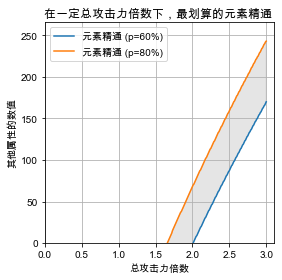

In [245]:
draw_rel(1.5, [.6, .8], .15, [2])

## 函数研究

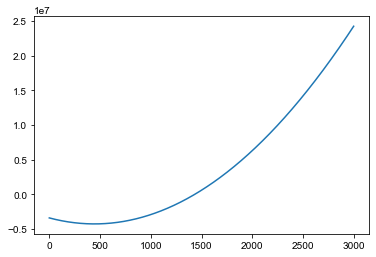

In [113]:
p = .6
EAR = 1.5
n = .15
c = 0.6
A = ((1 - p) / (p * EAR) + 3.777 + n)
B = -3892
C = -(20 * 3892) / .066 * (1 + 2 * c**2) / c
X = np.arange(0, 3000, 1)
Y = A * X ** 2 + B * X + C
plt.plot(X, Y)

In [70]:
# 中线

p = 1
EAR = 2
n = 0
c = 0.6
A = ((1 - p) / (p * EAR) + 3.777 + n)
B = -3892
C = -.066 / (20 * 3892) * (1 + 2 * c**2) / c

(-B+(B**2-4*A*C)**0.5)/(2*A)

1030.4474450628431

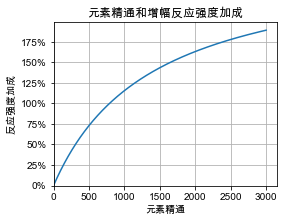

In [93]:
X = np.arange(0, 3000, 1)
Y = 2.777 - 3892 / (X + 1401)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(X, Y)
ax.set_ylabel('反应强度加成')
ax.set_xlabel('元素精通')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title('元素精通和增幅反应强度加成')
ax.grid()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.savefig('元素精通和增幅反应强度加成.png', dpi=800)